In [1]:
from mps_class_v9 import MPS
import numpy as np
from utils import tensor_shapes, H_ising_gen, mpo_to_matrix, mps_to_vector, truncation, single_site_op
from ncon import ncon
import scipy
from scipy.linalg import expm
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [51]:
def update_state_var(classe, sweep, site):
    if sweep == "right":
        # we want to write M (left,d,right) in LFC -> (left*d,right)
        m = classe.sites[site - 1].reshape(
            classe.env_left[-1].shape[0] * classe.d, classe.env_right[-1].shape[0]
        )
        u, s, v = np.linalg.svd(m, full_matrices=False)
        u = u.reshape(
            classe.env_left[-1].shape[0], classe.d, classe.env_right[-1].shape[0]
        )
        classe.sites[site - 1] = u
    elif sweep == "left":
        # we want to write M (left,d,right) in RFC -> (left,d*right)
        m = classe.sites[site - 1].reshape(
            classe.env_left[-1].shape[0], classe.d * classe.env_right[-1].shape[0]
        )
        u, s, v = np.linalg.svd(m, full_matrices=False)
        v = v.reshape(
            classe.env_left[-1].shape[0], classe.d, classe.env_right[-1].shape[0]
        )
        classe.sites[site - 1] = v

In [52]:
def lin_sys(classe, M, N_eff, site):
    M_new = M.flatten()
    new_site = scipy.linalg.solve(N_eff, M_new)
    new_site = new_site.reshape((classe.env_left[-1].shape[2], classe.d, classe.env_right[-1].shape[2]))
    classe.sites[site - 1] = new_site
    return classe

In [53]:
def time_ev_sweeping(classe, trunc, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=2, precision=2):
    sweeps = ["right", "left"]
    sites = np.arange(1, classe.L + 1).tolist()
    errors = []

    # computation of mixed environments
    classe.mpo_Ising_time_ev(delta=delta, h_ev=h_ev, J_ev=J_ev)
    classe.envs(site=1, mixed=True)
    iter = 1
    for n in range(n_sweeps):
        print(f"Sweep n: {n}\n")
        for i in range(classe.L - 1):
            N_eff = classe.N_eff(site=sites[i])
            classe, M = classe.contraction_with_ancilla(sites[i])
            lin_sys(classe, M, N_eff, sites[i])
            err = classe.error(site=sites[i], N_eff=N_eff, M=M)
            print(f"error per site {sites[i]}: {err:.5f}")
            errors.append(err)
            classe.update_state(sweeps[0], sites[i], trunc, e_tol, precision)
            classe.update_envs(sweeps[0], sites[i], mixed=True)
            iter += 1

        sweeps.reverse()
        sites.reverse()
    
    return classe, errors[-1]

In [36]:
Z = np.array([[1,0],[0,-1]])
def TEBD_ising(classe, trunc, trotter_steps, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=4, precision=2):
    errors = []
    classe.clear_envs()
    mag_tot = []
    for i in range(trotter_steps):
        print("\n======================")
        print(f"Trotter step: {i}")
        print("======================\n")
        classe, err = time_ev_sweeping(classe, trunc, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=2, precision=2)
        errors.append(err)
        print(f"Error at trotter step {i}: {err:.5f}")
        classe.clear_envs()
        mag_tot.append(classe.mps_local_exp_val(op=Z))
        classe.clear_envs()
    return classe, errors, mag_tot

In [78]:
trotter_steps = [1]
energies = []
# phi compressed and variational
chain = MPS(L=11, d=2, model="Ising", chi=16, h=0, J=1, eps=0)
chain._random_state(seed=7, chi=16)
chain.canonical_form()
chain.sweeping(trunc=False, n_sweeps=2)
chain._compute_norm(site=1)
chain.flipping_mps()

# psi uncompressed and fixed
guess = MPS(L=11, d=2, model="Ising", chi=32, h=0, J=1, eps=0)
guess._random_state(seed=7, chi=32)
guess.canonical_form()
guess.sweeping(trunc=False, n_sweeps=2)
guess._compute_norm(site=1)
guess.flipping_mps()
chain.ancilla_sites = guess.sites
chain.canonical_form(ancilla=True)
# chain._random_state(seed=5, chi=chain.chi, ancilla=True)
# chain.canonical_form(ancilla=True)

Sweep n: 0


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

Sweep n: 1


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

The left overlap of the state:
[[[[1]]]]
The right overlap of the state:
[[[[1.00000000e+00]]

  [[1.11022302e-16]]]


 [[[1.11022302e-16]]

  [[1.00000000e+00]]]]
The tensor in the site 1:
[[[[9.99210944e-01 6.23480257e-18]
   [6.23480257e-18 7.89055911e-04]]]]
-=-=-= Norm: 1.0

Sweep n: 0


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

Sweep n: 1


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

The left overlap of the state:
[[[[1]]]]
The right overlap of the state:
[[[[ 1.00000000e+00]]

  [[-1.11022302e-16]]]


 [[[-1.11022302e-16]]

  [[ 1.00000000e+00]]]]
The tensor in the site 1:
[[[[5.21847157e-01 1.08139474e-32]
   [1.08139474e-32 4.78152843e-01]]]]
-=-=-= Norm: 0.9999999999999997



In [62]:
vec = mps_to_vector(chain.sites).reshape(1,2**chain.L)
vec = truncation(vec, threshold=1e-15)
vec = csr_matrix(vec)
print(vec)

  (0, 2015)	0.9999999999999999


In [79]:
Z = np.array([[1,0],[0,-1]])
chain.clear_envs()
mag_init = chain.mps_local_exp_val(op=Z)
print(mag_init)

[array(0.99842189), array(0.99842189), array(0.99842189), array(0.99842189), array(0.99842189), array(-0.99842189), array(0.99842189), array(0.99842189), array(0.99842189), array(0.99842189), array(0.99842189)]


In [80]:
trotter_steps = [50]
for trott in trotter_steps:
    chain, errors, mag_mpo_tot = TEBD_ising(chain, trunc=False, trotter_steps=trott, delta=0.1, h_ev=0.3, J_ev=1)


Trotter step: 0

Sweep n: 0

(1, 1)
(2, 2)
error A^dagger N_eff A: (0.9912946711573086-5.551115123125783e-17j)
error A^dagger M: (0.9912946711573087+0j)
Total error: (-0.9912946711573088-5.551115123125783e-17j)
error per site 1: -0.99129-0.00000j
(2, 2)
(4, 4)
error A^dagger N_eff A: (0.9922522246678804+5.551115123125783e-17j)
error A^dagger M: (0.9922522246678804+0j)
Total error: (-0.9922522246678804+5.551115123125783e-17j)
error per site 2: -0.99225+0.00000j
(4, 4)
(8, 8)
error A^dagger N_eff A: (0.9934602729113288+0j)
error A^dagger M: (0.9934602729113288-5.551115123125783e-17j)
Total error: (-0.9934602729113288+0j)
error per site 3: -0.99346+0.00000j
(8, 8)
(16, 16)
error A^dagger N_eff A: (0.9953101005985968+1.3877787807814457e-17j)
error A^dagger M: (0.9953101005985969+2.7755575615628914e-17j)
Total error: (-0.995310100598597+1.3877787807814457e-17j)
error per site 4: -0.99531+0.00000j
(16, 16)
(32, 32)
error A^dagger N_eff A: (0.9983116118887445-2.7755575615628914e-17j)
error A

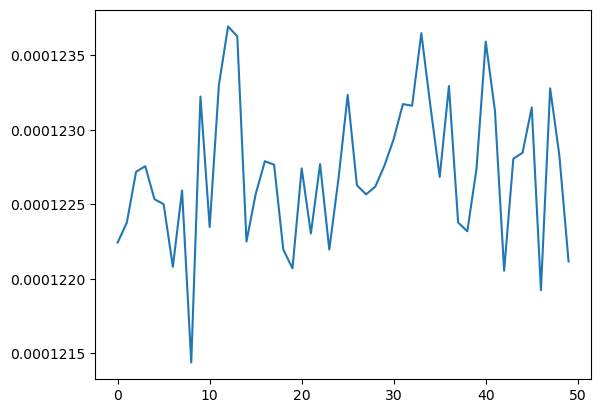

In [81]:
plt.plot(1+np.asarray(np.real(errors)))

In [82]:
errors = 1 + np.asarray(np.real(errors))
errors

array([0.00012224, 0.00012238, 0.00012272, 0.00012276, 0.00012253,
       0.0001225 , 0.00012208, 0.00012259, 0.00012144, 0.00012322,
       0.00012235, 0.0001233 , 0.00012369, 0.00012363, 0.00012225,
       0.00012257, 0.00012279, 0.00012277, 0.0001222 , 0.00012207,
       0.00012274, 0.0001223 , 0.00012277, 0.0001222 , 0.00012267,
       0.00012323, 0.00012263, 0.00012257, 0.00012262, 0.00012276,
       0.00012294, 0.00012317, 0.00012316, 0.00012365, 0.00012315,
       0.00012268, 0.00012329, 0.00012238, 0.00012232, 0.00012274,
       0.00012359, 0.00012313, 0.00012205, 0.00012281, 0.00012285,
       0.00012315, 0.00012192, 0.00012328, 0.00012283, 0.00012212])

In [83]:
mag = [np.real(mag_chain) for mag_chain in mag_mpo_tot]
mag = [mag_init, *mag]

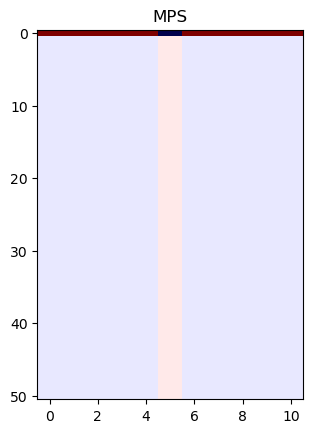

In [84]:
plt.title("MPS")
plt.imshow(mag, cmap="seismic", vmin=-1, vmax=1, aspect=0.3)
plt.show()

3.0 4.0


[]

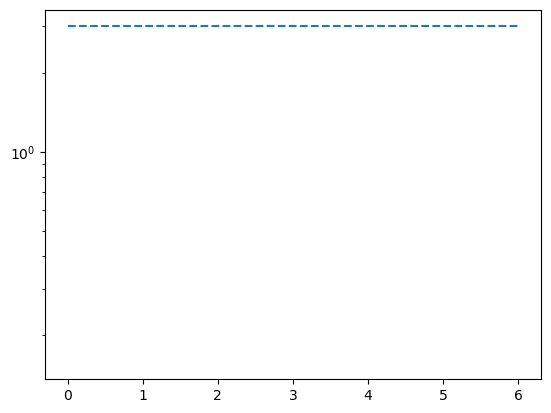

In [ ]:
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
H = H_ising_gen(L=4, op_l=Z, op_t=X, J=-1, h_l=0, h_t=0)
e,v = np.linalg.eig(H)
print(e[0], e[0]**2+1-2*e[0])
plt.plot(np.abs(energies))
plt.hlines(y=np.abs(e[0]), xmin=0, xmax=6, linestyle='--')
plt.semilogy()

In [ ]:
np.abs((energies[-1] - e[0])/energies[-1])

In [ ]:
errors

[-3.000064060873929,
 -3.000064070440773,
 -3.0000640642770655,
 -3.0000640703491634,
 -3.000064057409283]

In [18]:
spin = MPS(L=4, d=2, model="Ising", chi=4, J=1, h=0, eps=0)
spin._random_state(seed=3, chi=4)
spin.canonical_form()
energies = spin.sweeping(trunc=False)
print(energies)

Sweep n: 0


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

Sweep n: 1

[-1.5329019075206443, -2.9999999999999982, -3.0000000000000036, -3.0000000000000004, -3.000000000000002, -2.9999999999999987]


In [19]:
psi = mps_to_vector(spin.sites)

In [2]:
delta = 0.001
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
H = H_ising_gen(L=4, op_l=Z, op_t=X, J=1, h_l=0, h_t=0)
U = expm(-1j*delta*H)
for i in range(5):
    psi_new = ncon([U,psi],[[-1,1],[1]])

    eigval = ncon([psi_new.conjugate() , H , psi_new],[[1],[1,2],[2]]).real
    psi = psi_new
    print(f"energy at trotter step {i}: {eigval}")

NameError: name 'psi' is not defined

In [35]:
spin.mpo_Ising_time_ev(delta=delta, h_ev=0.1, J_ev=1)
mpo = spin.w
H_mpo = mpo_to_matrix(mpo)
U_mpo = expm(-1j*delta*H_mpo)
for i in range(5):
    psi_new = ncon([U_mpo,psi],[[-1,1],[1]])

    eigval = ncon([psi_new.conjugate() , H_mpo , psi_new],[[1],[1,2],[2]]).real
    psi = psi_new
    # print(psi_new)
    print(f"energy at trotter step {i}: {eigval}")

NameError: name 'spin' is not defined

In [ ]:
print(H_mpo.real)

[[ 9.99995320e-01 -5.99999264e-07 -2.99999332e-07 -8.99998542e-08
  -2.99999332e-07 -8.99997642e-08 -8.99998542e-08 -2.41069695e-36
  -5.99999264e-07 -8.99998542e-08 -8.99997642e-08  2.41069535e-30
  -8.99998542e-08  2.41069535e-30 -2.41069695e-36  8.09998736e-15]
 [-5.99999264e-07  9.99999320e-01 -8.99998542e-08 -2.99999932e-07
  -8.99997642e-08  2.99999332e-07  2.41069695e-36 -8.99998542e-08
  -8.99998542e-08  4.29490018e-23  2.41069535e-30 -8.99999442e-08
  -2.41069535e-30 -8.99998542e-08  8.09998736e-15  2.41069695e-36]
 [-2.99999332e-07 -8.99998542e-08  9.99999320e-01 -6.04105306e-23
  -8.99998542e-08 -2.41069695e-36  2.99999932e-07 -8.99999442e-08
  -8.99997642e-08  2.41069535e-30  5.99999264e-07 -8.99998542e-08
  -2.41069695e-36  8.09998736e-15 -8.99998542e-08 -2.41069535e-30]
 [-8.99998542e-08 -2.99999932e-07 -1.13981589e-22  9.99999320e-01
   2.41069695e-36 -8.99998542e-08 -8.99999442e-08 -2.99999932e-07
   2.41069535e-30 -8.99999442e-08 -8.99998542e-08 -9.58885610e-23
   8.09

In [37]:
print(U)

[[0.9999955+0.003j 0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j   ]
 [0.       +0.j    0.9999995+0.001j 0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j   ]
 [0.       +0.j    0.       +0.j    0.9999995-0.001j 0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j   ]
 [0.       +0.j    0.       +0.j    0.       +0.j    0.9999995+0.001j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0

In [23]:
def mpo_Ising_time_ev(classe, delta, h_ev, J_ev):
    """
    mpo_Ising_time_ev

    This function defines the MPO for the real time evolution of a 1D transverse field Ising model.
    We use this to perform a second order TEBD.

    delta: float - Trotter step for the time evolution
    h_ev: float - parameter of the local field for the quench
    J_ev: float - parameter of the interaction field for the quench

    """
    I = np.eye(2)
    O = np.zeros((2,2))
    X = np.array([[0,1],[1,0]])
    Z = np.array([[1,0],[0,-1]])
    w_tot = []
    w_loc = np.array(expm(1j*h_ev*delta/2*X)) 
    w_in = np.array([[np.sqrt(np.cos(J_ev*delta))*I, 1j*np.sqrt(np.sin(J_ev*delta))*Z]])
    w_in = ncon([w_in, w_loc, w_loc],[[-1,-2,1,2],[-3,1],[2,-4]])
    w_fin = np.array([[np.sqrt(np.cos(J_ev*delta))*I, np.sqrt(np.sin(J_ev*delta))*Z]])
    # w_fin = np.swapaxes(w_fin, axis1=0,axis2=1)
    w_fin = ncon([w_fin.T, w_loc, w_loc],[[1,2,-1,-2],[-3,1],[2,-4]])
    w_tot.append(w_in)
    for _ in range(1, classe.L-1):
        w = np.array([[np.cos(J_ev*delta)*I,1j*np.sqrt(np.cos(J_ev*delta)*np.sin(J_ev*delta))*Z],[np.sqrt(np.cos(J_ev*delta)*np.sin(J_ev*delta))*Z, 1j*np.sin(J_ev*delta)*I]])
        w = ncon([w, w_loc, w_loc],[[-1,-2,1,2],[-3,1],[2,-4]])
        w_tot.append(w)
    
    w_tot.append(w_fin)
    classe.w = w_tot
    return classe

In [76]:
classe = MPS(L=5, d=2, model="Ising", chi=4, h=0, J=1, eps=0)
mpo_Ising_time_ev(classe, delta=0.001, h_ev=0.3, J_ev=1)
mpo = classe.w
tensor_shapes(mpo)

(1, 2, 2, 2)
(2, 2, 2, 2)
(2, 2, 2, 2)
(2, 2, 2, 2)
(2, 1, 2, 2)


[(1, 2, 2, 2), (2, 2, 2, 2), (2, 2, 2, 2), (2, 2, 2, 2), (2, 1, 2, 2)]

In [77]:
U_mpo = mpo_to_matrix(mpo)
U_mpo = truncation(array=U_mpo, threshold=1e-16)
U_new_mpo = csr_matrix(U_mpo)

In [29]:
delta = 0.001
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
H = H_ising_gen(L=5, op_l=Z, op_t=X, J=1, h_l=0, h_t=0.3)
U = expm(-1j*delta*H)
U_new = truncation(array=U, threshold=1e-16)
U_new=csr_matrix(U_new)

In [56]:
print(U_new)

  (0, 0)	(0.9999919750107836+0.003999989260008664j)
  (0, 1)	(-2.9999949550028525e-07+9.999953116708575e-05j)
  (0, 2)	(-1.9999973033347853e-07+9.999973116688374e-05j)
  (0, 3)	(-9.99996981668655e-09-2.3333305710012463e-11j)
  (0, 4)	(-1.9999973033347845e-07+9.999973116688342e-05j)
  (0, 5)	(-9.999986483340616e-09-9.999989883337628e-12j)
  (0, 6)	(-9.999986483340618e-09-1.3333322493337719e-11j)
  (0, 7)	(1.666665249222891e-15-9.999981850009447e-13j)
  (0, 8)	(-1.9999973033347853e-07+9.999973116688375e-05j)
  (0, 9)	(-9.999986483340616e-09-9.999989883337631e-12j)
  (0, 10)	(-9.999986483340618e-09+3.1290276259521427e-27j)
  (0, 11)	(3.333330398890258e-16-9.999989850004314e-13j)
  (0, 12)	(-9.99998648334062e-09-1.333332249333772e-11j)
  (0, 13)	(3.3333303988902554e-16-9.99999318333576e-13j)
  (0, 14)	(6.666663020001485e-16-9.99999185000331e-13j)
  (0, 16)	(-2.9999949550028525e-07+9.999953116708575e-05j)
  (0, 17)	(-9.999976483347366e-09-1.9999979766675255e-11j)
  (0, 18)	(-9.9999864833406

In [59]:
print(U_new_mpo)

  (0, 0)	(0.9999919750107775+0.0039999892733420086j)
  (0, 1)	(-2.999993965004471e-07+9.99994978339069e-05j)
  (0, 2)	(-1.9999946433376532e-07+9.999959783387342e-05j)
  (0, 3)	(-9.999969816697123e-09-1.9999966500022953e-11j)
  (0, 4)	(-1.9999946433376632e-07+9.999959783387242e-05j)
  (0, 5)	(-9.999969816697123e-09-9.99997325002156e-12j)
  (0, 6)	(-9.99997981669371e-09-9.999973250021562e-12j)
  (0, 7)	(9.999983283344754e-16-9.999979850016975e-13j)
  (0, 8)	(-1.9999946433376532e-07+9.999959783387342e-05j)
  (0, 9)	(-9.999969816697123e-09-9.999973250021559e-12j)
  (0, 10)	(-9.99995981672054e-09+0j)
  (0, 12)	(-9.99997981669371e-09-9.999973250021562e-12j)
  (0, 16)	(-2.999993965004471e-07+9.99994978339069e-05j)
  (0, 17)	(-9.999969816697123e-09-1.999996650002295e-11j)
  (0, 18)	(-9.999969816697124e-09-9.99997325002156e-12j)
  (0, 19)	(9.999983283344754e-16-9.999979850016973e-13j)
  (0, 20)	(-9.999969816697123e-09-9.999973250021562e-12j)
  (0, 24)	(-9.999969816697126e-09-1.9999966500022956e

In [71]:
np.isclose(U_new, U_new_mpo)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [21]:
L = 11
delta = 0.6
H = H_ising_gen(L=L, op_l=Z, op_t=X, J=1, h_l=0, h_t=0)
e, v = np.linalg.eig(H)
psi = v[:,0]
flip = single_site_op(op=X, site=L // 2 + 1, L=L)
psi = flip @ psi
H_ev = H_ising_gen(L=L, op_l=Z, op_t=X, J=1, h_l=0, h_t=0.3)
U = expm(-1j*delta*H_ev)
U_new = truncation(array=U, threshold=1e-16)
U_new=csr_matrix(U_new)

In [24]:
L = 11
spin = MPS(L=L, d=2, model="Ising", chi=32, J=1, h=0, eps=0)
spin._random_state(seed=3, chi=32)
spin.canonical_form()
energies = spin.sweeping(trunc=True)
print(energies)
spin.flipping_mps()
sites = [np.abs(site) for site in spin.sites]
psi_mpo = mps_to_vector(sites)
mpo_Ising_time_ev(spin, delta=delta, h_ev=0.3, J_ev=1)
mpo = spin.w
U_mpo = mpo_to_matrix(mpo)
U_mpo = truncation(array=U_mpo, threshold=1e-16)
U_new_mpo = csr_matrix(U_mpo)

Sweep n: 0

Sweep n: 1

[-0.6045105522026742, -2.9188088142080915, -4.924802561013979, -6.368712210695969, -8.945210494883584, -10.000000000000004, -10.000000000000004, -9.999999999999996, -10.000000000000002, -10.0, -9.999999999999996, -9.999999999999996, -9.999999999999998, -9.999999999999996, -9.999999999999998, -9.999999999999996, -9.999999999999996, -9.999999999999995, -9.999999999999996, -9.999999999999996]


In [25]:
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
magnetization = [single_site_op(op=Z, site=i, L=L) for i in range(1,L+1)]
mag_exact = []
for i in range(L):
    mag_exact.append(psi.T.conjugate() @ magnetization[i] @ psi)
print("magnetization exact:\n", mag_exact)
mag_mpo = []
for i in range(L):
    mag_mpo.append(psi_mpo.T.conjugate() @ magnetization[i] @ psi_mpo)
print("magnetization mpo:\n", mag_mpo)
print("\n")

magnetization exact:
 [1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
magnetization mpo:
 [0.9999999999999996, 0.9999999999999996, 0.9999999999999996, 0.9999999999999996, 0.9999999999999996, -0.9999999999999996, 0.9999999999999996, 0.9999999999999996, 0.9999999999999996, 0.9999999999999996, 0.9999999999999996]




In [26]:
psi_new = psi
psi_new_mpo = psi_mpo
mag_exact_tot = []
mag_mpo_tot = []
trotter_steps = 8
overlap = []
for j in range(trotter_steps):
    psi_new = U_new @ psi_new
    mag_exact = []
    for i in range(L):
        mag_exact.append((psi_new.T.conjugate() @ magnetization[i] @ psi_new).real)
    print(f"----- trotter step {j} --------")
    print("magnetization exact:\n", mag_exact)
    mag_mpo = []
    psi_new_mpo = U_new_mpo @ psi_new_mpo
    for i in range(L):
        mag_mpo.append((psi_new_mpo.T.conjugate() @ magnetization[i] @ psi_new_mpo).real)
    print("magnetization mpo:\n", mag_mpo)
    print("\n")
    overlap.append(psi_new.T.conjugate() @ psi_new_mpo)
    mag_exact_tot.append(mag_exact)
    mag_mpo_tot.append(mag_mpo)

----- trotter step 0 --------
magnetization exact:
 [0.9432137305479228, 0.9608622555795413, 0.9608861572938172, 0.9608665542626493, 0.9363062326326166, -0.96084704632997, 0.9363062326326163, 0.9608665542626498, 0.9608861572938163, 0.9608622555795416, 0.9432137305479229]
magnetization mpo:
 [0.9563342703330882, 0.9906906359457113, 0.9906906350725599, 0.9906906372068618, 0.9367892380009661, -0.9906906333546247, 0.9367892380009668, 0.990690637206862, 0.9906906350725597, 0.9906906359457112, 0.9563342703330877]


----- trotter step 1 --------
magnetization exact:
 [0.8495080055003973, 0.9668631164935613, 0.9699076411014445, 0.9671124350534128, 0.7634277344618164, -0.9644657998228374, 0.7634277344618159, 0.9671021162297049, 0.9699076411014432, 0.9668527976698522, 0.8495080055003977]
magnetization mpo:
 [0.8830524088566943, 0.9863693582638776, 0.9907033547264825, 0.9850024121197741, 0.7615050610104028, -0.9799225704515248, 0.7615050610104027, 0.9850024121197744, 0.9907033547264829, 0.9863693

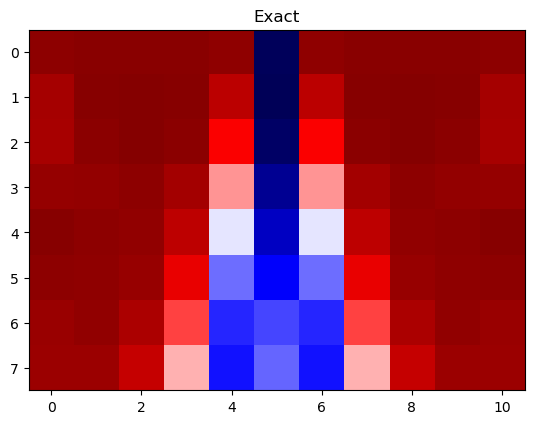

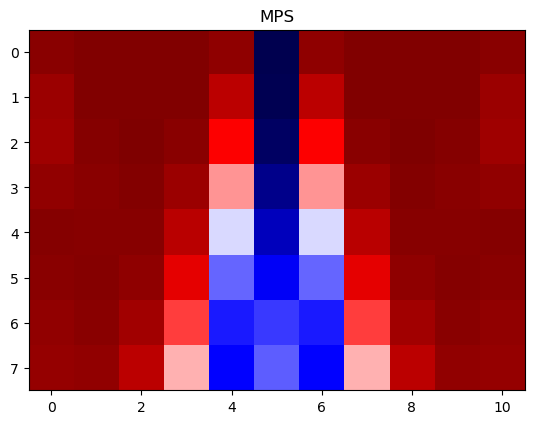

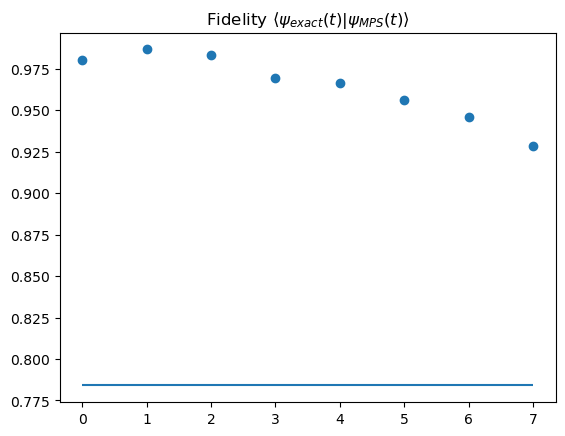

In [34]:
plt.title("Exact")
plt.imshow(mag_exact_tot, cmap="seismic", vmin=-1, vmax=1, aspect=1)
plt.show()
plt.title("MPS")
plt.imshow(mag_mpo_tot, cmap="seismic", vmin=-1, vmax=1, aspect=1)
plt.show()
plt.title("Fidelity $\left<\psi_{exact}(t)|\psi_{MPS}(t)\\right>$")
plt.plot(overlap, 'o')
plt.hlines(y=1-delta**3, xmin=0, xmax=7)
plt.show()

In [44]:
L = 11
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
spin = MPS(L=L, d=2, model="Ising", chi=32, J=1, h=0, eps=0)
spin._random_state(seed=3, chi=32)
spin.canonical_form()
energies = spin.sweeping(trunc=True)
spin.flipping_mps()
mag_init = spin.mps_local_exp_val(op=Z)
print(mag_init)

Sweep n: 0

Sweep n: 1

[array(1.), array(1.), array(1.), array(1.), array(1.), array(-1.), array(1.), array(1.), array(1.), array(1.), array(1.)]


In [45]:
psi_new = psi
mag_exact_tot = []
mag_mpo_tot = []
trotter_steps = 8
overlap = []
for T in range(trotter_steps):
    psi_new = U_new @ psi_new
    mag_exact = []
    for i in range(L):
        mag_exact.append((psi_new.T.conjugate() @ magnetization[i] @ psi_new).real)
    print(f"----- trotter step {T} --------")
    mag_exact_tot.append(mag_exact)
    print(f"Bond dim: {spin.sites[spin.L//2].shape[0]}")
    spin.mpo_Ising_time_ev(delta=delta, h_ev=0.3, J_ev=1)
    spin.mpo_to_mps()
    mag_mpo_tot.append(spin.mps_local_exp_val(op=Z))
    psi_new_mpo = mps_to_vector(spin.sites)
    overlap.append(psi_new.T.conjugate() @ psi_new_mpo)

----- trotter step 0 --------
Bond dim: 1
----- trotter step 1 --------
Bond dim: 2
----- trotter step 2 --------
Bond dim: 4
----- trotter step 3 --------
Bond dim: 8
----- trotter step 4 --------
Bond dim: 16
----- trotter step 5 --------
Bond dim: 32
----- trotter step 6 --------
Bond dim: 64
----- trotter step 7 --------
Bond dim: 128


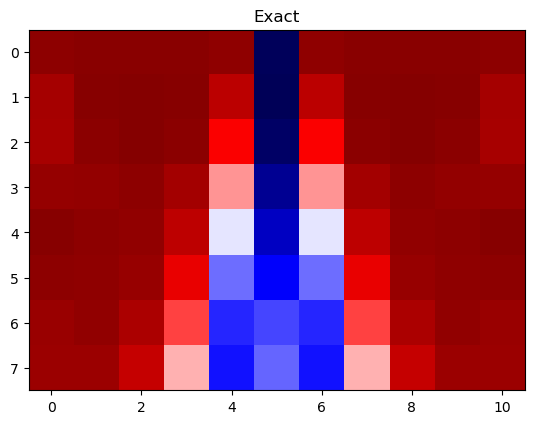

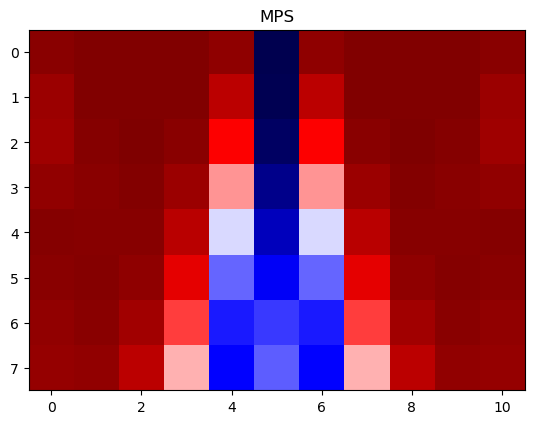

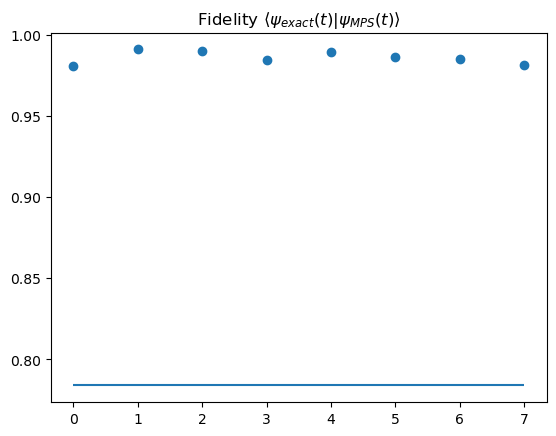

In [46]:
mag_mpo_tot = [np.real(mag_chain) for mag_chain in mag_mpo_tot]
plt.title("Exact")
plt.imshow(mag_exact_tot, cmap="seismic", vmin=-1, vmax=1, aspect=1)
plt.show()
plt.title("MPS")
plt.imshow(mag_mpo_tot, cmap="seismic", vmin=-1, vmax=1, aspect=1)
plt.show()
plt.title("Fidelity $\left<\psi_{exact}(t)|\psi_{MPS}(t)\\right>$")
plt.plot(np.abs(overlap), 'o')
plt.hlines(y=1-delta**3, xmin=0, xmax=7)
plt.show()

In [47]:
overlap

[(0.9804019474441988-0.01819607540865852j),
 (0.9866575071975736-0.091676589334184j),
 (0.9833503840054758-0.11350140825593884j),
 (0.969526299651093-0.17172588427810442j),
 (0.9665736189728402-0.210053751504697j),
 (0.956118658164658-0.24089873633778092j),
 (0.9456164625379312-0.2753078408149697j),
 (0.9283251313689295-0.31735674714781853j)]